In [102]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score,GridSearchCV

In [103]:
df = pd.read_excel('../data/model_annotations_liwc_h.xlsx')
df_human = pd.read_excel("../data/r1_r2_annotations_liwc_h.xlsx")

In [104]:
df.drop(['text','Segment'],axis=1,inplace=True)

In [105]:
df_human.rename({'majority_vote':'model_unanimous'},axis=1, inplace=True)
df_human.drop(['Segment','text','A1','A2','A3','A4','A5','A6','roundID'], axis=1,inplace=True)
df_human=df_human[df_human['model_unanimous']!='NoMajority']

In [106]:
df_human

,proc_text,model_unanimous,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Fuck you china. I was 2 years clear of severe ...,PP,26,4.85,7.93,81.58,1.00,8.67,26.92,92.31,...,0.0,0.00,26.92,7.69,3.85,0.00,0.00,3.85,11.54,0.00
1,Feeling so off today and I can’t tell if this ...,PP,25,1.00,1.00,85.71,1.00,12.50,16.00,96.00,...,0.0,0.00,28.00,12.00,0.00,0.00,0.00,8.00,8.00,16.00
2,Good lord people we need to stop having people...,PP,42,29.12,40.06,72.58,1.00,14.00,21.43,85.71,...,0.0,0.00,19.05,4.76,0.00,0.00,0.00,4.76,9.52,0.00
3,"I'm telling yall, Chill the fuck out!! This Vi...",PO,43,30.58,17.05,82.44,3.38,4.78,20.93,93.02,...,0.0,0.00,37.21,4.65,2.33,0.00,23.26,2.33,4.65,0.00
4,Episode of #CoronaVirus panic. Man took his gl...,PP,58,63.33,9.86,97.87,1.05,9.67,8.62,91.38,...,0.0,1.72,20.69,10.34,5.17,0.00,0.00,3.45,1.72,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,"Afternoon all, \n\nToday I share with you the ...",UN,26,89.52,98.04,11.63,99.00,26.00,50.00,69.23,...,0.0,0.00,46.15,0.00,3.85,0.00,0.00,0.00,42.31,3.85
513,"In the UK, the chasm betwn people’s willingnes...",PO,41,99.00,26.81,87.24,1.00,20.50,36.59,68.29,...,0.0,0.00,31.71,0.00,12.20,0.00,2.44,2.44,14.63,0.00
516,Stay physically fit &amp; healthy during self-...,UN,40,92.56,26.50,78.67,2.86,8.00,32.50,77.50,...,0.0,0.00,37.50,12.50,2.50,0.00,0.00,0.00,22.50,0.00
518,I have just uploaded my 11th video in my serie...,UN,40,89.52,26.50,45.52,1.00,13.33,25.00,82.50,...,0.0,0.00,32.50,5.00,5.00,0.00,0.00,5.00,17.50,0.00


In [107]:
df_new = pd.concat([df,df_human],axis=0)

In [108]:
def add_unsupervised_columns(data):
    text = data['proc_text']
    X = data.drop(columns=['model_unanimous','proc_text'], axis=1)
    y = data['model_unanimous']
    
    from sklearn.feature_extraction.text import TfidfVectorizer


    tfidf = TfidfVectorizer(analyzer='word'
                            , min_df=0.05
                            , stop_words='english')
    tfidf_wm = tfidf.fit_transform(text)
    tfidf_tokens = tfidf.get_feature_names_out()
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

    X = pd.concat([df_tfidfvect, X], axis=1)
    

    from sklearn.feature_selection import VarianceThreshold

    thresholder = VarianceThreshold()
    X_high_variance = thresholder.fit_transform(X)
    mask = thresholder.get_support(indices=True)
    feature_names_high_variance = X.columns[mask]
    X_high_variance = pd.DataFrame(X_high_variance, columns=feature_names_high_variance)



    print("X shape:", X.shape)
    print("X_high_variance shape:", X_high_variance.shape)
    
    return X_high_variance

In [109]:
df_new = df_new[~df_new.duplicated()]


In [110]:
df_new.head()

,proc_text,model_unanimous,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,"Dear World:family_man_woman_girl_boy:, you nee...",PO,32,52.84,75.49,1.63,1.00,16.0,46.88,75.00,...,0.0,0.0,59.38,3.13,6.25,0.0,0.0,0.00,50.00,12.5
1,.@fordnation says releasing the projection mod...,PO,28,96.35,3.12,48.09,1.00,28.0,35.71,82.14,...,0.0,0.0,32.14,3.57,3.57,0.0,0.0,3.57,21.43,0.0
2,"""Neurologists around the world say that a smal...",UN,34,93.03,24.36,4.60,20.23,17.0,29.41,85.29,...,0.0,0.0,20.59,2.94,0.00,0.0,0.0,2.94,14.71,0.0
3,Coronavirus: More than one million cases confi...,UN,34,93.03,40.06,12.44,1.85,17.0,41.18,85.29,...,0.0,0.0,14.71,5.88,0.00,0.0,0.0,0.00,8.82,0.0
4,"This is my Gov, @henrymcmaster, today, 4/2/202...",UN,42,81.45,54.27,72.58,3.20,10.5,30.95,78.57,...,0.0,0.0,38.10,7.14,11.90,0.0,0.0,2.38,16.67,0.0


In [111]:
def add_unsupervised_columns(data):
    text = data['proc_text']
    X = data.drop(columns=['model_unanimous','proc_text'], axis=1)
    y = data['model_unanimous']
    
    from sklearn.feature_extraction.text import TfidfVectorizer


    tfidf = TfidfVectorizer(analyzer='word'
                            , min_df=0.05
                            , stop_words='english')
    tfidf_wm = tfidf.fit_transform(text)
    tfidf_tokens = tfidf.get_feature_names_out()
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

    X = pd.concat([df_tfidfvect, X], axis=1)
    

    from sklearn.feature_selection import VarianceThreshold

    thresholder = VarianceThreshold()
    X_high_variance = thresholder.fit_transform(X)
    mask = thresholder.get_support(indices=True)
    feature_names_high_variance = X.columns[mask]
    X_high_variance = pd.DataFrame(X_high_variance, columns=feature_names_high_variance)



    print("X shape:", X.shape)
    print("X_high_variance shape:", X_high_variance.shape)
    
    return X_high_variance

In [112]:
data=df_new.copy()

text = data['proc_text']
X = data.drop(columns=['model_unanimous','proc_text'], axis=1)
y = data['model_unanimous']

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(analyzer='word'
                            , min_df=0.05
                            , stop_words='english')
tfidf_wm = tfidf.fit_transform(text)
tfidf_tokens = tfidf.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

df_tfidfvect.reset_index(drop=True,inplace=True)
X.reset_index(drop=True,inplace=True)

X = pd.concat([df_tfidfvect, X], axis=1)

In [114]:
y.reset_index(inplace=True,drop=True)
y

0        PO
1        PO
2        UN
3        UN
4        UN
         ..
13026    UN
13027    PO
13028    UN
13029    UN
13030    PO
Name: model_unanimous, Length: 13031, dtype: object

In [115]:
round(y.value_counts()*100/len(y),3)

model_unanimous
PO    54.877
UN    37.227
PP     7.897
Name: count, dtype: float64

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2,random_state=704)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10424, 144), (2607, 144), (10424,), (2607,))

In [117]:
def reset_idx():
    X_train.reset_index(drop=True,inplace=True)
    X_test.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    y_test.reset_index(drop=True,inplace=True)

In [118]:
reset_idx()

In [119]:
X_train.head()

,19,amp,breath,buying,chill,coronavirus,covid,covid19,covid_19,don,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.662254,0.000000,...,0.0,0.0,33.33,0.00,0.00,5.56,0.0,0.00,27.78,5.56
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.440643,0.000000,0.799014,...,0.0,0.0,55.56,16.67,0.00,0.00,0.0,16.67,22.22,0.00
2,0.0,0.000000,0.0,0.0,0.0,0.435132,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,34.09,2.27,9.09,2.27,0.0,0.00,20.45,0.00
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.732803,0.000000,0.000000,...,0.0,0.0,41.18,5.88,5.88,5.88,0.0,0.00,23.53,0.00
4,0.0,0.939361,0.0,0.0,0.0,0.000000,0.0,0.251301,0.000000,0.000000,...,0.0,0.0,26.83,4.88,4.88,0.00,0.0,2.44,14.63,0.00


In [120]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [121]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()

reg.fit(X_train, y_train)

y_pred_test=reg.predict(X_test)

# print(classification_report(y_test,y_pred_test))

# conf_m=confusion_matrix(y_test,y_pred_test)

# ConfusionMatrixDisplay(conf_m).plot()

# with open('models/regression_1.pkl','wb') as file:
#     pickle.dump(reg, file)

# with open('models/regression_1.pkl','rb') as file:
#     reg = pickle.load(file)

c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [122]:
X_train.isna().sum().sum()

0

In [123]:
def plot_pdf(data,r,c,size=(15,10)):
  plt.figure(figsize=size)
  for i in range(len(data.columns)):
    plt.subplot(r,c,i+1)
    sns.histplot(data[data.columns[i]],kde=True)
    plt.xlabel(data.columns[i])
    plt.grid()
  plt.show()

def plot_box(data,r,c,size=(15,10)):
  plt.figure(figsize=size)
  for i in range(len(data.columns)):
    plt.subplot(r,c,i+1)
    sns.boxplot(data[data.columns[i]])
    plt.xlabel(data.columns[i])
  plt.show()

In [124]:
def evaluate_classifier(clf,X_train,y_train,X_test,y_test):
    print(f"TRAIN PERFORMANCE")
    y_pred_train=clf.predict(X_train)
    print(f"Cross validation scores: {cross_val_score(clf,X_train,y_train)}")

    print(classification_report(y_train,y_pred_train))

    conf_m=confusion_matrix(y_train,y_pred_train)

    ConfusionMatrixDisplay(conf_m).plot()


    print(f"\n\nTEST PERFORMANCE")
    y_pred_test=clf.predict(X_test)

    print(classification_report(y_test,y_pred_test))

    conf_m=confusion_matrix(y_test,y_pred_test)

    ConfusionMatrixDisplay(conf_m).plot()

c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

TRAIN PERFORMANCE


c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Cross validation scores: [0.9558753  0.958753   0.95971223 0.95971223 0.96401152]
              precision    recall  f1-score   support

          PO       0.99      0.99      0.99      5732
          PP       0.85      0.83      0.84       814
          UN       0.97      0.96      0.97      3878

    accuracy                           0.97     10424
   macro avg       0.94      0.93      0.93     10424
weighted avg       0.97      0.97      0.97     10424



TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.98      0.99      0.98      1419
          PP       0.81      0.79      0.80       215
          UN       0.96      0.96      0.96       973

    accuracy                           0.96      2607
   macro avg       0.92      0.91      0.91      2607
weighted avg       0.96      0.96      0.96      2607



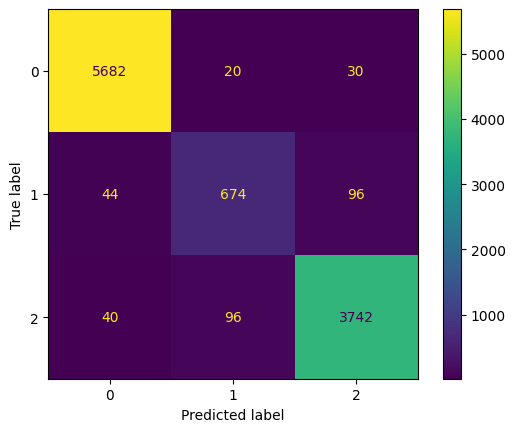

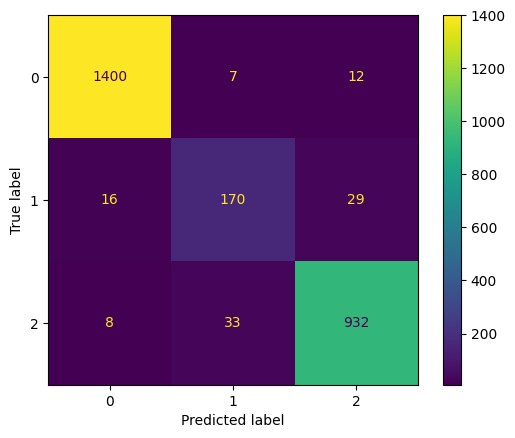

In [125]:
from sklearn.linear_model import LogisticRegression

param_grid={'penalty':['l1','l2',None],'C':[0.001,0.01,0.1,1,10]}

reg = GridSearchCV(LogisticRegression(max_iter=500),param_grid=param_grid)

reg.fit(X_train, y_train)

evaluate_classifier(reg,X_train,y_train,X_test,y_test)

In [126]:
# with open('models/regression_unsup.pkl','wb') as file:
#     pickle.dump(reg, file)

# with open('models/regression_unsup.pkl','rb') as file:
#     reg = pickle.load(file)

In [127]:
from sklearn.ensemble import RandomForestClassifier

param_grid={'n_estimators': [100,500], 'max_depth':[3,5,7]}

rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)

rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7], 'n_estimators': [100, 500]})

In [128]:
rf.best_params_

{'max_depth': 7, 'n_estimators': 500}

TRAIN PERFORMANCE
Cross validation scores: [0.95059952 0.95635492 0.95971223 0.96067146 0.96017274]
              precision    recall  f1-score   support

          PO       0.98      1.00      0.99      5732
          PP       0.96      0.68      0.80       814
          UN       0.96      0.99      0.98      3878

    accuracy                           0.97     10424
   macro avg       0.97      0.89      0.92     10424
weighted avg       0.97      0.97      0.97     10424



TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.97      0.99      0.98      1419
          PP       0.90      0.54      0.68       215
          UN       0.93      0.98      0.96       973

    accuracy                           0.95      2607
   macro avg       0.94      0.84      0.87      2607
weighted avg       0.95      0.95      0.95      2607



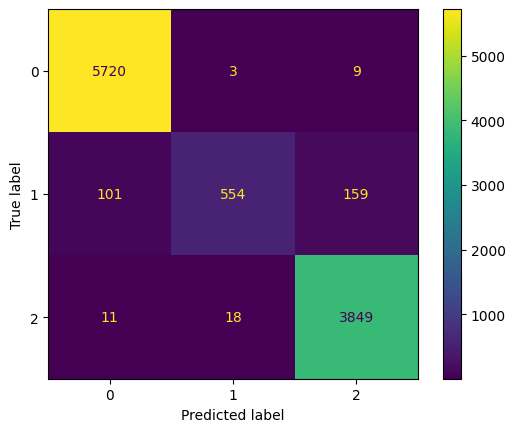

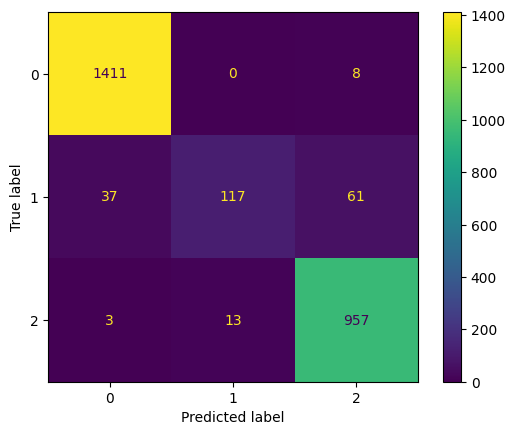

In [129]:
evaluate_classifier(rf,X_train,y_train,X_test,y_test)

In [130]:
df_human

,proc_text,model_unanimous,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Fuck you china. I was 2 years clear of severe ...,PP,26,4.85,7.93,81.58,1.00,8.67,26.92,92.31,...,0.0,0.00,26.92,7.69,3.85,0.00,0.00,3.85,11.54,0.00
1,Feeling so off today and I can’t tell if this ...,PP,25,1.00,1.00,85.71,1.00,12.50,16.00,96.00,...,0.0,0.00,28.00,12.00,0.00,0.00,0.00,8.00,8.00,16.00
2,Good lord people we need to stop having people...,PP,42,29.12,40.06,72.58,1.00,14.00,21.43,85.71,...,0.0,0.00,19.05,4.76,0.00,0.00,0.00,4.76,9.52,0.00
3,"I'm telling yall, Chill the fuck out!! This Vi...",PO,43,30.58,17.05,82.44,3.38,4.78,20.93,93.02,...,0.0,0.00,37.21,4.65,2.33,0.00,23.26,2.33,4.65,0.00
4,Episode of #CoronaVirus panic. Man took his gl...,PP,58,63.33,9.86,97.87,1.05,9.67,8.62,91.38,...,0.0,1.72,20.69,10.34,5.17,0.00,0.00,3.45,1.72,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,"Afternoon all, \n\nToday I share with you the ...",UN,26,89.52,98.04,11.63,99.00,26.00,50.00,69.23,...,0.0,0.00,46.15,0.00,3.85,0.00,0.00,0.00,42.31,3.85
513,"In the UK, the chasm betwn people’s willingnes...",PO,41,99.00,26.81,87.24,1.00,20.50,36.59,68.29,...,0.0,0.00,31.71,0.00,12.20,0.00,2.44,2.44,14.63,0.00
516,Stay physically fit &amp; healthy during self-...,UN,40,92.56,26.50,78.67,2.86,8.00,32.50,77.50,...,0.0,0.00,37.50,12.50,2.50,0.00,0.00,0.00,22.50,0.00
518,I have just uploaded my 11th video in my serie...,UN,40,89.52,26.50,45.52,1.00,13.33,25.00,82.50,...,0.0,0.00,32.50,5.00,5.00,0.00,0.00,5.00,17.50,0.00


In [131]:
rf.predict(X_train)

array(['UN', 'PO', 'PO', ..., 'UN', 'PO', 'PO'], dtype=object)

In [132]:
y_train

0        UN
1        PO
2        PO
3        PO
4        PO
         ..
10419    PP
10420    PO
10421    UN
10422    PO
10423    PO
Name: model_unanimous, Length: 10424, dtype: object

In [ ]:
with open('models/rf_unsup.pkl','wb') as file:
    pickle.dump(rf, file)

with open('models/rf_unsup.pkl','rb') as file:
    reg = pickle.load(file)